## Unit 4 Unsupervised Learning Capstone Project

For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

Dataset: https://www.kaggle.com/snap/amazon-fine-food-reviews

In [2]:
#Basic imports 
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

#NLP imports 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

#Dimension Reduction 
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

#Clustering 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

#Clustering Evaluation 
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

#Model Imports  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#Model Optimization 
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix

#Time
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shuaix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('https://www.dropbox.com/s/d4ye48a67tth2ae/Reviews.csv?dl=1')

In [4]:
#drop uneccessary columns 
df.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time', 'Summary'],axis=1,inplace=True)
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
Score    568454 non-null int64
Text     568454 non-null object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [7]:
df.isnull().sum()

Score    0
Text     0
dtype: int64

In [8]:
# Remove duplicate reviews  
df.drop_duplicates(subset=['Score','Text'],keep='first',inplace=True)

In [9]:
df.Score.value_counts()

5    250745
4     56074
1     36280
3     29772
2     20804
Name: Score, dtype: int64

In [10]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    
    text = re.sub(r'--',' ',text)
    
    # Removes hyperlinks 
    text = re.sub(r'<a\s+href=(?:"([^"]+)"|\'([^\']+)\').*?>(.*?)</a>',' ', text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    # Lowercase text
    text = text.lower()
    
    return text

In [11]:
df['Clean'] = df['Text'].apply(lambda x: text_cleaner(x))

In [12]:
# Create Utility function to lemmatize our text reviews limiting variations on same words
lemma = spacy.lang.en.English()

def lemma_text(text):
    tokens = lemma(text) 
    return([token.lemma_ for token in tokens if not token.is_punct and not token.is_stop])

df['lemma_text'] = df.Clean.apply(lemma_text)

In [13]:
df.head()

,Score,Text,Clean,lemma_text
0,5,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,"[buy, vitality, can, dog, food, product, find,..."
1,1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,"[product, arrive, label, jumbo, salt, peanut, ..."
2,4,This is a confection that has been around a fe...,this is a confection that has been around a fe...,"[confection, century, light, pillowy, citrus, ..."
3,2,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,"[look, secret, ingredient, robitussin, believe..."
4,5,Great taffy at a great price. There was a wid...,great taffy at a great price. there was a wide...,"[great, taffy, great, price, wide, assortment,..."


## Feature Generation

In [14]:
# Identifying variables
X = df['Clean']
y = df['Score']

# Splitting into train and test sets, reserve 40% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

In [15]:
# Total word count 
feature_df = pd.DataFrame()
feature_df['word_count'] = [len(x.split()) for x in X_train.tolist()]

# Count of punctuations 
feature_df['exclamation_marks'] = X_train.str.findall(r'[!]').str.len()
feature_df['periods'] = X_train.str.findall(r'[.]').str.len()
feature_df['question_marks'] = X_train.str.findall(r'[?]').str.len()
feature_df['Text'] = X_train
feature_df['Score'] = y_train

In [16]:
# Let's check our new features
feature_df.head()

,word_count,exclamation_marks,periods,question_marks,Text,Score
0,64,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,204,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,175,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,86,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,60,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


In [17]:
# Initialize vectorizer 
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             tokenizer=lemma_text)


# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.40, random_state=0)

Number of features: 69650


## Dimensionality Reduction

In [18]:
#Our SVD data reducer.  We are going to reduce the feature space from upwards of 70k to 1500 
#Ideally we would try to capture no less than 90% variance in the dataset, but due to computational limitations, we'll have to sacrifice variance
svd= TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 54.44782775510504


In [19]:
tfidf_df = pd.DataFrame(data=X_train_lsa)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.138526,-0.019096,-0.009700,-0.091483,-0.041705,0.043097,-0.143737,0.060551,-0.029851,0.122997,...,-0.000889,0.003325,0.006177,0.010482,0.001096,0.009684,0.005829,-0.010128,0.000880,-0.000569
1,0.243905,-0.047781,-0.012217,-0.127877,-0.086277,0.078432,-0.099155,0.049713,-0.042611,0.048570,...,0.025811,-0.011107,0.008496,-0.010481,-0.009029,-0.001121,-0.032290,0.022005,0.001010,-0.003441
2,0.333545,-0.177561,-0.064060,0.134972,-0.003156,0.004314,-0.123386,-0.212981,0.079521,0.039691,...,0.000126,0.004511,-0.003231,0.004600,0.006492,0.004050,-0.003285,-0.014750,0.010687,-0.008051
3,0.328098,-0.016633,0.013271,-0.102437,0.034822,-0.105802,-0.053813,0.023793,0.013748,0.169843,...,-0.023803,-0.042325,0.011858,-0.029245,0.033723,0.008265,-0.009333,0.007773,0.001593,0.030719
4,0.219915,-0.069933,-0.018156,-0.056984,-0.085022,0.111803,-0.044039,-0.027794,-0.120207,0.011918,...,-0.011015,0.048171,-0.026972,-0.010325,-0.049737,-0.031136,-0.004143,0.044464,0.007657,0.054161


In [20]:
new_df = pd.concat([tfidf_df, feature_df], ignore_index=False, axis=1)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,word_count,exclamation_marks,periods,question_marks,Text,Score
0,0.138526,-0.019096,-0.009700,-0.091483,-0.041705,0.043097,-0.143737,0.060551,-0.029851,0.122997,...,0.005829,-0.010128,0.000880,-0.000569,64,0.0,3.0,0.0,i have bought several of the vitality canned d...,5.0
1,0.243905,-0.047781,-0.012217,-0.127877,-0.086277,0.078432,-0.099155,0.049713,-0.042611,0.048570,...,-0.032290,0.022005,0.001010,-0.003441,204,0.0,5.0,0.0,product arrived labeled as jumbo salted peanut...,1.0
2,0.333545,-0.177561,-0.064060,0.134972,-0.003156,0.004314,-0.123386,-0.212981,0.079521,0.039691,...,-0.003285,-0.014750,0.010687,-0.008051,175,0.0,9.0,0.0,this is a confection that has been around a fe...,4.0
3,0.328098,-0.016633,0.013271,-0.102437,0.034822,-0.105802,-0.053813,0.023793,0.013748,0.169843,...,-0.009333,0.007773,0.001593,0.030719,86,0.0,3.0,0.0,if you are looking for the secret ingredient i...,2.0
4,0.219915,-0.069933,-0.018156,-0.056984,-0.085022,0.111803,-0.044039,-0.027794,-0.120207,0.011918,...,-0.004143,0.044464,0.007657,0.054161,60,0.0,4.0,0.0,great taffy at a great price. there was a wide...,5.0


In [21]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()

## Clustering

In [22]:
# Declare clustering variables  
features = new_df.drop(['Score','Text'], axis=1)
predict = new_df['Score']

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Clustering algorithms need normalization
scalar = MinMaxScaler()

scaled = scalar.fit_transform(features)
scaled_df = pd.DataFrame(scaled)

c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### KMeans

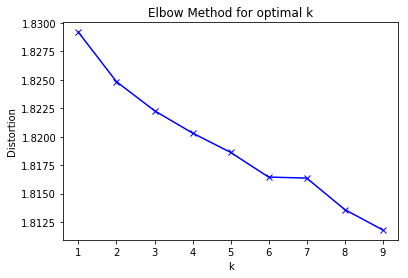

In [24]:
# Let's see what the elbow curve tells us would be the optimal K value 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled)
    kmeanModel.fit(scaled)
    distortions.append(sum(np.min(cdist(scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

looks like 2 clusters are best per the elbow method, perhaps due to sentiment in the reviews

In [25]:
# Declare and fit clustering model using K of 5 for our 5 scores
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(scaled)

pd.crosstab(predict, y_pred)

col_0,0,1,2,3,4
Score,,,,,
1.0,2764,832,474,676,5661
2.0,1598,514,239,401,3304
3.0,2398,688,364,599,4607
4.0,4272,1317,681,1066,8977
5.0,18773,5479,2982,4523,38715


In [26]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(predict, y_pred)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(scaled, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.0026518
Silhouette Score: -0.020762


### Minibatch KMeans

In [27]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(scaled)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(scaled)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0      0      1     2      3  4
Score                              
1.0     3973   4255   697   1482  0
2.0     2283   2469   378    925  1
3.0     3267   3589   566   1234  0
4.0     6203   6580  1080   2450  0
5.0    26976  28515  4741  10240  0


In [28]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(predict, predict_mini)))
print('Silhouette Score: {:0.5}'.format(silhouette_score(scaled, predict_mini, metric='euclidean')))

Adjusted Rand Score: -0.00024463
Silhouette Score: -0.011988


From what we can see with these two clustering methods scores being close to zero, it appears that most of the observations lie between two clusters.

## Modeling: Training Set

### Logistic Regression: Training Set

In [29]:
lr = LogisticRegression(class_weight = 'balanced')
train = lr.fit(scaled, predict)
lr_scores = cross_val_score(lr, scaled, predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))

c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", F


Cross Validation Training Scores:0.58371(+/- 0.003)


In [30]:
from sklearn.metrics import classification_report

sk_lr_report = classification_report(
    digits=6,
    y_true=predict, 
    y_pred=lr.predict(scaled))
print('\nClasification report:\n', sk_lr_report)

sk_lr_report2 = confusion_matrix(y_true=predict, y_pred=lr.predict(scaled))

print('\nConfusion Matrix:\n',sk_lr_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.228627  0.056789  0.090979     10407
         2.0   0.137237  0.075462  0.097379      6056
         3.0   0.178031  0.072089  0.102623      8656
         4.0   0.266446  0.034512  0.061109     16313
         5.0   0.650507  0.926496  0.764351     70472

   micro avg   0.603437  0.603437  0.603437    111904
   macro avg   0.292170  0.233070  0.223288    111904
weighted avg   0.490961  0.603437  0.511930    111904


Confusion Matrix:
 [[  591   392   432   233  8759]
 [  212   457   249   135  5003]
 [  278   352   624   227  7175]
 [  403   588   617   563 14142]
 [ 1101  1541  1583   955 65292]]


## Random Forest: Training Set

In [31]:
rfc = RandomForestClassifier(class_weight = 'balanced_subsample')
train = rfc.fit(scaled, predict)
rfc_scores = cross_val_score(rfc, scaled, predict, cv=5)

print('\nCross Validation Training Scores:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))

c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Cross Validation Training Scores:0.60154(+/- 0.001)


In [32]:
sk_rfc_report = classification_report(
    digits=6,
    y_true=predict, 
    y_pred=rfc.predict(scaled))
print('\nClasification report:\n', sk_rfc_report)

sk_rfc_report2 = confusion_matrix(y_true=predict, y_pred=rfc.predict(scaled))

print('\nConfusion Matrix:\n',sk_rfc_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.998207  0.962717  0.980141     10407
         2.0   0.999484  0.959379  0.979021      6056
         3.0   0.999041  0.962338  0.980346      8656
         4.0   0.998165  0.966959  0.982314     16313
         5.0   0.979642  0.999674  0.989556     70472

   micro avg   0.986399  0.986399  0.986399    111904
   macro avg   0.994908  0.970213  0.982276    111904
weighted avg   0.986643  0.986399  0.986342    111904


Confusion Matrix:
 [[10019     1     1     5   381]
 [    5  5810     2     3   236]
 [    3     0  8330     5   318]
 [    8     0     2 15774   529]
 [    2     2     3    16 70449]]


## Modeling: Test Set

We'll need to process the test group as we did the training set above.

In [33]:
# Total word count 
feature_df_test = pd.DataFrame()
feature_df_test['word_count'] = [len(x.split()) for x in X_test.tolist()]

# Count of punctuations 
feature_df_test['exclamation_marks'] = X_test.str.findall(r'[!]').str.len()
feature_df_test['periods'] = X_test.str.findall(r'[.]').str.len()
feature_df_test['question_marks'] = X_test.str.findall(r'[?]').str.len()
feature_df_test['Text'] = X_test
feature_df_test['Score'] = y_test

In [34]:
#Our SVD data reducer.  We are going to reduce the feature space to 800 again for test.
svd= TruncatedSVD(800)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 54.64595748970055


In [35]:
tfidf_df_test = pd.DataFrame(data=X_test_lsa)
tfidf_df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.149010,-0.056183,-0.001003,-0.101753,-0.100769,-0.030476,0.090389,0.064680,-0.012433,-0.076608,...,0.019578,-0.012207,0.026662,0.043037,-0.038824,0.005555,0.030779,-0.004697,0.000172,-0.010152
1,0.224022,-0.158376,0.001396,0.211602,-0.155638,-0.016718,-0.070060,-0.003110,-0.098705,-0.003249,...,-0.000253,0.005644,-0.005310,0.009057,-0.004556,-0.007875,0.008396,-0.013870,0.002466,-0.006937
2,0.217265,-0.103008,-0.007078,-0.037072,0.058375,-0.042559,-0.024804,0.068597,0.059574,0.023518,...,0.025184,0.002302,0.001509,0.006538,0.028943,-0.014825,-0.006719,-0.009710,0.005816,-0.011967
3,0.210651,0.009628,0.009356,-0.113185,-0.149731,0.042603,-0.054715,-0.049735,-0.079807,0.012954,...,-0.013249,0.012708,0.002658,0.005951,-0.023002,0.004106,-0.013160,0.008318,-0.002015,-0.006701
4,0.165193,-0.078425,0.007443,0.044326,0.110497,0.027904,-0.029237,0.020718,-0.053072,-0.016590,...,0.011991,-0.011280,0.006777,0.005868,-0.012937,0.012778,-0.002174,0.011590,0.018691,-0.003250


In [36]:
new_df = pd.concat([tfidf_df_test, feature_df_test], ignore_index=False, axis=1)
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,word_count,exclamation_marks,periods,question_marks,Text,Score
0,0.149010,-0.056183,-0.001003,-0.101753,-0.100769,-0.030476,0.090389,0.064680,-0.012433,-0.076608,...,0.030779,-0.004697,0.000172,-0.010152,65,NaN,NaN,NaN,NaN,NaN
1,0.224022,-0.158376,0.001396,0.211602,-0.155638,-0.016718,-0.070060,-0.003110,-0.098705,-0.003249,...,0.008396,-0.013870,0.002466,-0.006937,30,NaN,NaN,NaN,NaN,NaN
2,0.217265,-0.103008,-0.007078,-0.037072,0.058375,-0.042559,-0.024804,0.068597,0.059574,0.023518,...,-0.006719,-0.009710,0.005816,-0.011967,58,NaN,NaN,NaN,NaN,NaN
3,0.210651,0.009628,0.009356,-0.113185,-0.149731,0.042603,-0.054715,-0.049735,-0.079807,0.012954,...,-0.013160,0.008318,-0.002015,-0.006701,115,NaN,NaN,NaN,NaN,NaN
4,0.165193,-0.078425,0.007443,0.044326,0.110497,0.027904,-0.029237,0.020718,-0.053072,-0.016590,...,-0.002174,0.011590,0.018691,-0.003250,76,NaN,NaN,NaN,NaN,NaN


In [37]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()

In [38]:
# Declare variables  
test_features = new_df.drop(['Score','Text'], axis=1)
test_predict = new_df['Score']

# Normalize data 
scalar = MinMaxScaler()

test_scaled = scalar.fit_transform(test_features)
test_df = pd.DataFrame(test_scaled)

c:\users\shuaix\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## KMeans

In [39]:
# Declare and fit clustering model using K of 5 for our 5 scores
kmeans = KMeans(n_clusters=5, random_state=0)
y_pred = kmeans.fit_predict(test_scaled)

pd.crosstab(test_predict, y_pred)

col_0,0,1,2,3,4
Score,,,,,
1.0,262,2410,674,1293,213
2.0,147,1453,355,760,128
3.0,229,2172,551,1119,188
4.0,433,3875,1046,2061,345
5.0,1761,16933,4495,9175,1399


In [40]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(test_predict, y_pred)))

Adjusted Rand Score: 0.00071531


### Minibatch KMeans

In [41]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=200)
minibatchkmeans.fit(test_scaled)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(test_scaled)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(test_predict, predict_mini))

Comparing k-means and mini batch k-means solutions:
col_0    0      1      2     3     4
Score                               
1.0     22   1821   2206   253   550
2.0     24   1104   1259   157   299
3.0     31   1612   1903   217   496
4.0     48   2923   3498   426   865
5.0    231  12581  15388  1756  3807


In [42]:
print('Adjusted Rand Score: {:0.5}'.format(adjusted_rand_score(test_predict, predict_mini)))

Adjusted Rand Score: 0.00057498


### Logistic Regression: Test Set

In [43]:
print('Logistic Regression Test Score: {:0.5}'.format(lr.score(test_scaled, test_predict)))

Logistic Regression Test Score: 0.33665


In [44]:
sk_lr_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=lr.predict(test_scaled))
print('\nClasification report:\n', sk_lr_report)

sk_lr_report2 = confusion_matrix(y_true=test_predict, y_pred=lr.predict(test_scaled))

print('\nConfusion Matrix:\n',sk_lr_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.200000  0.001443  0.002865      4852
         2.0   0.066401  0.720366  0.121594      2843
         3.0   0.076142  0.003522  0.006732      4259
         4.0   0.147975  0.012242  0.022614      7760
         5.0   0.727849  0.469093  0.570502     33763

   micro avg   0.336649  0.336649  0.336649     53477
   macro avg   0.243673  0.241333  0.144861     53477
weighted avg   0.508744  0.336649  0.370732     53477


Confusion Matrix:
 [[    7  3119    26    57  1643]
 [    4  2048    22    39   730]
 [    4  3148    15    70  1022]
 [    5  5092    41    95  2527]
 [   15 17436    93   381 15838]]


### Random Forest: Test Set

In [45]:
print('Random Forest Test Score: {:0.5}'.format(rfc.score(test_scaled, test_predict)))

Random Forest Test Score: 0.59543


In [46]:
sk_rfc_report = classification_report(
    digits=6,
    y_true=test_predict, 
    y_pred=rfc.predict(test_scaled))
print('\nClasification report:\n', sk_rfc_report)

sk_rfc_report2 = confusion_matrix(y_true=test_predict, y_pred=rfc.predict(test_scaled))

print('\nConfusion Matrix:\n',sk_rfc_report2)


Clasification report:
               precision    recall  f1-score   support

         1.0   0.092531  0.017106  0.028875      4852
         2.0   0.073434  0.011959  0.020569      2843
         3.0   0.097601  0.027706  0.043160      4259
         4.0   0.141176  0.023196  0.039845      7760
         5.0   0.633188  0.930812  0.753681     33763

   micro avg   0.595434  0.595434  0.595434     53477
   macro avg   0.207586  0.202156  0.177226     53477
weighted avg   0.440325  0.595434  0.488773     53477


Confusion Matrix:
 [[   83    42   115   124  4488]
 [   59    34    72    70  2608]
 [   97    43   118   108  3893]
 [  110    74   179   180  7217]
 [  548   270   725   793 31427]]


### Conclusion

Modeling versus Clustering?

Overall, our supervised models were much better at classifying reviews than clustering. Though our models did tend to overfit on the test set.

Unfortunately we weren't able to test many different clustering methods given the size of the dataset and computational limitations, and thus our Kmeans cluster was effectively the 'best' given its ability to actualy execute on the dataset.

Ideally, we would be able to keep around 90% of the variance in our truncated SVD, but due to computational limitations, I was only able to perform clustering and modeling with 50% of the variance kept. Without this limitation, we would likely see an increase in our clustering and modeling methods.

In the future, I would like to fine tune parameters on our clusters and models, increase our variance incorporated on the tfidf vectorizer to see if we can better our overall performances.